In [1]:
import numpy as np
# import BigNumber as bn


In [2]:
def encode_R_to_C(message: np.ndarray, n: int):
    # encode the message (length = n * col, double) into complex number (length = n * col, complex)
    message = np.reshape(message, (-1, n // 2)).T
    complex_message = message[:,::2] - 1j * np.flipud(message[:,1::2])
    complex_message = np.concatenate((complex_message, np.flipud(np.conj(complex_message))), axis=0)
    return complex_message

def encode_C_to_C(message: np.ndarray, n: int):
    # encode the message (length = n * col, complex double) into complex number (length = n * (2 * col), complex)
    message = np.reshape(message, (-1, n // 2)).T
    complex_message = np.concatenate((message, np.flipud(np.conj(message))), axis=0)
    return complex_message

def decode_C_to_R(complex_message: np.ndarray, n: int):
    # decode the complex number (length = n * col, complex) into message (length = n * col, double)
    message = np.concatenate((np.real(complex_message[: n // 2]), -np.flipud(np.imag(complex_message[: n // 2]))), axis=0)
    return message.T.flatten()

def decode_C_to_C(complex_message: np.ndarray, n: int):
    # decode the complex number (length = n * col, complex) into message (length = n * (col / 2), complex double)
    message = complex_message[: n // 2].T.flatten()
    return message

def encode(message: np.ndarray, n: int, delta: float, type_is_C=0):
    # encode the message (length = n * col, double) into plaintext of rings of degree n (shape [n, col], int)
    complex_message = encode_R_to_C(message, n) if not type_is_C else encode_C_to_C(message, n)
    x = (np.outer(np.arange(1, 2 * n + 1, 2), np.arange(n)) % (n * 2)).T
    plaintext = np.round(np.real(np.exp(1j * np.pi / n * x) @ complex_message) / n * delta)
    return plaintext

def decode(plaintext: np.ndarray, n: int, delta: float, type_is_C=0):
    # decode the plaintext of rings of degree n (shape [n, col], int) into the message (length = n * col, double)
    x = np.outer(np.arange(1, 2 * n + 1, 2), np.arange(n)) % (n * 2)
    complex_message = np.exp(-1j * np.pi / n * x) @ plaintext / delta
    message = decode_C_to_R(complex_message, n) if not type_is_C else decode_C_to_C(complex_message, n)
    return message

In [3]:
def sample_error_vector(n: int, sigma: float):
    # sample from the standard normal distribution of length n with variance sigma^2
    return np.random.normal(0, sigma, n)

def sample_ring(n: int, q: int):
    # sample from the integer modulo ring, uniform distribution integers [-q/2, q/2) of length n
    return np.random.randint(-q // 2, q // 2, n).astype(np.int64)

def sample_triple_value_vector_with_rho(n: int, rho=0.5):
    # sample integers {0, 1, -1} of probability {1-rho, rho/2, rho/2} of length n
    return np.round(np.random.uniform(-2 * rho, 2 * rho, n)).astype(np.int64)

def sample_triple_value_vector_with_hamming_weight(n: int, hamming_weight: int):
    # sample integers {0, 1, -1} of length n with hamming weight hamming_weight
    res = np.zeros(n)
    res[np.random.choice(n, hamming_weight, replace=False)] = np.random.choice([1, -1], hamming_weight)
    return res

def sample_error_vector_multicolumn(n: int, col: int, sigma: float):
    return sample_error_vector(n * col, sigma).reshape(n, col)

def sample_triple_value_vector_with_rho_multicolumn(n: int, col: int, rho=0.5):
    return sample_triple_value_vector_with_rho(n * col, rho).reshape(n, col)

def sample_triple_value_vector_with_hamming_weight_multicolumn(n: int, col: int, hamming_weight: int):
    return np.array([sample_triple_value_vector_with_hamming_weight(n, hamming_weight) for _ in range(col)]).T

In [4]:
def key_gen(n: int, q: int, sigma: float, hamming_weight: int):
    # generate the secret key (sk) and public key (pk) (tuple([n], [n]))
    s = sample_triple_value_vector_with_hamming_weight(n, hamming_weight)
    a = sample_ring(n, q)
    e = sample_error_vector(n, sigma)
    sk = (np.ones(n), s)
    pk = (-a * s + e, a)
    return sk, pk

def multiply_along_axis(A, B, axis):
    return np.swapaxes(np.swapaxes(A, axis, -1) * B, -1, axis)

def encrypt(plaintext: np.ndarray, n: int, sigma: float, pk: tuple[np.ndarray, np.ndarray]):
    # encrypt the plaintext (shape [n, col], int) into ciphertext (tuple([n, col], [n, col]), int)
    e0, e1 = sample_error_vector_multicolumn(n, plaintext.shape[1], sigma), sample_error_vector_multicolumn(n, plaintext.shape[1], sigma)
    v = sample_triple_value_vector_with_rho_multicolumn(n, plaintext.shape[1])
    ciphertext = (plaintext + e0, e1) + (multiply_along_axis(v, pk[0], 0), multiply_along_axis(v, pk[1], 0))
    return ciphertext

def decrypt(ciphertext: tuple[np.ndarray, np.ndarray], n: int, sk: tuple[np.ndarray, np.ndarray]):
    # decrypt the ciphertext (tuple([n, col], [n, col]), int) into plaintext (shape [n, col], int)
    return ciphertext[0] + multiply_along_axis(ciphertext[1], sk[1], 0)

In [5]:
def encode_and_encrypt(message: np.ndarray, n: int, delta: float, sigma: float, pk: tuple[np.ndarray, np.ndarray]):  
    return encrypt(encode(message, n, delta), n, sigma, pk)

def decode_and_decrypt(ciphertext: tuple[np.ndarray, np.ndarray], n: int, delta: float, sk: tuple[np.ndarray, np.ndarray]):
    return decode(decrypt(ciphertext, n, delta, sk), n, delta)

def ciphertext_mul(ciphertext1: tuple[np.ndarray, np.ndarray], ciphertext2: tuple[np.ndarray, np.ndarray]):
    return (ciphertext1[0] * ciphertext2[0], ciphertext1[0] * ciphertext2[1] + ciphertext1[1] * ciphertext2[0])

def ciphertext_add(ciphertext1: tuple[np.ndarray, np.ndarray], ciphertext2: tuple[np.ndarray, np.ndarray]):
    return (ciphertext1[0] + ciphertext2[0], ciphertext1[1] + ciphertext2[1])

def ciphertext_sub(ciphertext1: tuple[np.ndarray, np.ndarray], ciphertext2: tuple[np.ndarray, np.ndarray]):
    return (ciphertext1[0] - ciphertext2[0], ciphertext1[1] - ciphertext2[1])

def ciphertext_avg(ciphertext: tuple[np.ndarray, np.ndarray]):
    return (ciphertext[0].mean(axis=0), ciphertext[1].mean(axis=0))


In [6]:
n = 2 ** 4 # n must be power of 2
q = 2 ** 10
delta = 64
sigma = 3.2
hamming_weight = 2
sk, pk = key_gen(n, q, sigma, hamming_weight)
print(sk[0].shape)
print(pk[0].shape)

message = np.arange(n * 2) # Test message: 0, 1, 2, ..., 2n-1
plaintext = encode(message, n, delta)
print("plaintext:", plaintext)
ciphertext = encrypt(plaintext, n, sigma, pk)
# print(ciphertext[0])
# print(ciphertext[1])
decrypted = decrypt(ciphertext, n, sk)
print(decrypted)
decoded = decode(decrypted, n, delta)
print(decoded)

(16,)
(16,)
plaintext: [[ 224. 1248.]
 [ 368. 1025.]
 [  84.   84.]
 [ 155.  385.]
 [  45.   45.]
 [ 107.  261.]
 [  35.   35.]
 [  93.  223.]
 [  32.   32.]
 [  95.  225.]
 [  35.   35.]
 [ 114.  268.]
 [  45.   45.]
 [ 176.  407.]
 [  84.   84.]
 [ 575. 1231.]]
[[ 226.68726345 1254.41422835]
 [ 364.63677667 1024.39438453]
 [  88.71307682   87.83573992]
 [ 148.07308979  387.19655904]
 [  45.95739482   44.6123189 ]
 [ 107.8954449   262.57351349]
 [  33.46377491   34.18233309]
 [ 100.90130294  226.89659091]
 [  33.78816575   28.34497128]
 [  96.37770502  220.70196929]
 [  34.93384712   36.12021028]
 [ 117.56146523  265.45349561]
 [  48.76940942   44.39559817]
 [ 173.10589057  411.42500238]
 [  86.08262138   84.91138106]
 [ 576.39243122 1231.10952397]]
[-0.1003432   1.04410685  2.11082825  2.85864901  4.10482652  4.96138602
  6.1759075   7.18054696  8.00186526  8.58217285  9.86643587 11.14616417
 12.06217821 13.05773997 13.84808945 15.21601252 16.14449583 17.02192074
 18.20091282 19.0198

In [7]:
import os
os.environ["OMP_NUM_THREADS"] = "8"  # set the number of CPU threads to use for parallel regions

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Initialization of ML parameters

# Set the length of the input/output vectors
N = n  # Features
w = np.random.randint(0, 2, (N,)).astype(np.float32)  # shape (1, N)
w = 2 * w - 1
batch_size = 32
epochs = 200

# permutation_w = np.random.permutation(N)
# reverse_permutation_w = np.argsort(permutation_w)
# w_permuted = w[permutation_w]

L = 1024  # Number of samples
X_train = np.random.randint(-1, 2, (L, N)).astype(np.float32)  # shape (L, N)
Y_train = (X_train * w.T).astype(np.float32)  # shape (L, N)

print(f"{w}\n{X_train[0, :]}\n{Y_train[0, :]}")

[ 1. -1.  1. -1. -1. -1.  1. -1. -1. -1. -1.  1. -1.  1.  1. -1.]
[-1.  1.  0.  0. -1.  0.  0. -1.  1.  1. -1.  0.  1.  0.  1.  1.]
[-1. -1.  0. -0.  1. -0.  0.  1. -1. -1.  1.  0. -1.  0.  1. -1.]


In [8]:
plaintext_set_X = encode(X_train, n, delta) # shape [N, L]
plaintext_set_Y = encode(Y_train, n, delta) # shape [N, L]

print(plaintext_set_X.shape)
print(plaintext_set_Y.shape)

ciphertext_set_X = encrypt(plaintext_set_X, n, sigma, pk) # Tuple ([N, L], [N, L]) 
ciphertext_set_Y = encrypt(plaintext_set_Y, n, sigma, pk) # Tuple ([N, L], [N, L])

print(ciphertext_set_X[0].shape)
print(ciphertext_set_Y[0].shape)

(16, 1024)
(16, 1024)
(16, 1024)
(16, 1024)


In [9]:
# Create the weight vector as a trainable variable
class LinearLayer_enc(nn.Module):
    def __init__(self, units):
        super(LinearLayer_enc, self).__init__()
        self.kernel = nn.Parameter(torch.zeros(units)) 
        print(self.kernel.data.shape)
        
    def forward(self, inputs):
        weights = encode_and_encrypt(self.kernel.data.detach().numpy(), n, delta, sigma, pk)
        ciphertext_result = ciphertext_mul(inputs, weights)
        return ciphertext_result

# Define the neural network model
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.layer = LinearLayer_enc(N)

    def forward(self, x):
        return self.layer(x)

In [10]:
# Create the weight vector as a trainable variable
class LinearLayer_ecd(nn.Module):
    def __init__(self, units):
        super(LinearLayer_ecd, self).__init__()
        # Reshape kernel to [N, 1] for broadcasting
        self.kernel = nn.Parameter(torch.zeros(units).unsqueeze(1))
        # print(self.kernel.data.shape)
        
    def forward(self, inputs):
        # inputs are real integers, shape [N, Batch_size]
        outputs = inputs * self.kernel
        return outputs
    
# Define the neural network model
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.layer = LinearLayer_ecd(N)

    def forward(self, x):
        return self.layer(x)

In [11]:
'''
# Initialize model, loss function, and optimizer
model1 = Model1()

criterion = nn.MSELoss()

permutation_batch = np.random.permutation(L)
batch_num = L // batch_size
batch_idx = permutation_batch.reshape((batch_num, batch_size))

print(batch_idx.shape)

X_train_tensors = [(ciphertext_set_X[0][:,batch_idx[i]], ciphertext_set_X[1][:,batch_idx[i]]) for i in range(batch_num)]
Y_train_tensors = [(ciphertext_set_Y[0][:,batch_idx[i]], ciphertext_set_Y[1][:,batch_idx[i]]) for i in range(batch_num)]

def calculate_gradient(x, y_pred, y):
    diff_y = ciphertext_sub(y, y_pred)
    x_grad = ciphertext_mul(x, diff_y)
    x_grad = ciphertext_avg(x_grad)
    return x_grad

def perform_gradient_descent_step(kernel, x_grad, learning_rate=0.001):
    kernel.data += learning_rate * x_grad

# Train the model
for epoch in range(epochs):
    for i in range(batch_num):
        x, y = X_train_tensors[i], Y_train_tensors[i]
        for step in range(1):
            y_pred = model1(x)
            loss = criterion(torch.tensor(y_pred[0], requires_grad=True), torch.tensor(y[0], requires_grad=True))
            x_grad = calculate_gradient(x, y_pred, y)
            x_grad_dec = decode_and_decrypt(x_grad, n, delta, sk)
            # print(x_grad_dec)
            perform_gradient_descent_step(model1.layer.kernel, x_grad_dec, 5e-6)
    print(f"Epoch {epoch + 1}, Loss: {loss}")
    # print(model.layer.kernel.data)

w_trained = model1.layer.kernel.data.numpy()
print(w_trained, w)
'''

'\n# Initialize model, loss function, and optimizer\nmodel1 = Model1()\n\ncriterion = nn.MSELoss()\n\npermutation_batch = np.random.permutation(L)\nbatch_num = L // batch_size\nbatch_idx = permutation_batch.reshape((batch_num, batch_size))\n\nprint(batch_idx.shape)\n\nX_train_tensors = [(ciphertext_set_X[0][:,batch_idx[i]], ciphertext_set_X[1][:,batch_idx[i]]) for i in range(batch_num)]\nY_train_tensors = [(ciphertext_set_Y[0][:,batch_idx[i]], ciphertext_set_Y[1][:,batch_idx[i]]) for i in range(batch_num)]\n\ndef calculate_gradient(x, y_pred, y):\n    diff_y = ciphertext_sub(y, y_pred)\n    x_grad = ciphertext_mul(x, diff_y)\n    x_grad = ciphertext_avg(x_grad)\n    return x_grad\n\ndef perform_gradient_descent_step(kernel, x_grad, learning_rate=0.001):\n    kernel.data += learning_rate * x_grad\n\n# Train the model\nfor epoch in range(epochs):\n    for i in range(batch_num):\n        x, y = X_train_tensors[i], Y_train_tensors[i]\n        for step in range(1):\n            y_pred = mod

In [12]:
# Initialize model, loss function, and optimizer
model2 = Model2()

optimizer = optim.Adam(model2.parameters(), lr=0.1)
criterion = nn.MSELoss()

# permutation_batch = np.random.permutation(L)
permutation_batch = np.arange(L)
batch_num = L // batch_size
batch_idx = permutation_batch.reshape((batch_num, batch_size))

print(batch_idx.shape)

X_train_tensors = [torch.Tensor(plaintext_set_X[:,batch_idx[i]]) for i in range(batch_num)]
Y_train_tensors = [torch.Tensor(plaintext_set_Y[:,batch_idx[i]]) for i in range(batch_num)]

print(X_train_tensors[0].shape)


(32, 32)
torch.Size([16, 32])


In [13]:
# Define the neural network
class ColumnMappingNN(nn.Module):
    def __init__(self, input_size, kernel_size, num_filters):
        super(ColumnMappingNN, self).__init__()
        
        # Linear layer to map the input to a hidden layer
        
        self.conv1 = nn.Conv1d(in_channels=1,  
                                out_channels=4, 
                                kernel_size=5,
                                padding=2)
        
        # Activation function (ReLU)
        self.relu = nn.ReLU()
        
        # Activation function (Sigmoid)
        self.sigmoid = nn.Sigmoid()
        
        self.pool = nn.AvgPool1d(kernel_size=2)
        # Output layer that maps the hidden layer back to the output size
        self.linear = nn.Linear(N, N)
        
        self.conv2 = nn.Conv1d(in_channels=4,  
                                out_channels=1, 
                                kernel_size=5,
                                padding=6)
    
    def forward(self, x):
        
        x = x.unsqueeze(1) # [batch_size, N] -> [batch_size, 1, N]
        
        x = self.conv1(x) # [batch_size, 1, N] -> [batch_size, num_filters, N - (kernel_size - 1) + 2 * padding]

        x = torch.square(x)
        
        x = self.pool(x)

        x = self.conv2(x).squeeze(1)

        return x

# Create random integer input and output datasets
# input_data = [torch.Tensor(plaintext_set_X[:,batch_idx[i]].T) for i in range(batch_num)]
# output_data = [torch.Tensor(plaintext_set_Y[:,batch_idx[i]].T) for i in range(batch_num)]

input_data = [torch.Tensor(ciphertext_set_X[0][:,batch_idx[i]].T) for i in range(batch_num)]
output_data = [torch.Tensor(ciphertext_set_Y[0][:,batch_idx[i]].T) for i in range(batch_num)]


# Initialize the network
model = ColumnMappingNN(input_size=batch_size, kernel_size=N // 4, num_filters=4)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean squared error loss for regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.0019)


In [14]:
class ColumnMappingNN_2(nn.Module):
    def __init__(self, input_size, num_filters):
        super(ColumnMappingNN_2, self).__init__()

        # Convolutional Layer 1
        self.conv1 = nn.Conv1d(in_channels=1,  
                               out_channels=num_filters, 
                               kernel_size=3,
                               padding=1)
        
        # Batch Norm
        self.bn1 = nn.BatchNorm1d(num_filters)
        
        # Max Pooling
        self.pool = nn.MaxPool1d(kernel_size=2)

        # Convolutional Layer 2
        self.conv2 = nn.Conv1d(in_channels=num_filters, 
                               out_channels=1, 
                               kernel_size=3, 
                               padding=1)
        
        # Fully Connected Layer
        self.fc = nn.Linear(input_size // 2, input_size)
        
        # Dropout Layer
        self.dropout = nn.Dropout(0.3)

        # Activation Function (ReLU)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension: [batch_size, 1, num_features]

        # First Convolution + Batch Norm + ReLU + Pooling
        x = self.conv1(x)
        # x = self.bn1(x)
        # x = self.relu(x)
        x = torch.square(x)
        x = torch.sigmoid(x)
        x = self.pool(x)

        # Second Convolution + Pooling
        x = self.conv2(x)
        # x = torch.square(x)
        
        # x = self.relu(x)

        # Flatten and Fully Connected Layer + Dropout
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)
        # x = self.dropout(x)

        return x

input_data = [torch.Tensor(ciphertext_set_X[0][:,batch_idx[i]].T) for i in range(batch_num)]
output_data = [torch.Tensor(ciphertext_set_Y[0][:,batch_idx[i]].T) for i in range(batch_num)]


# Initialize the network
model = ColumnMappingNN_2(input_size=N, num_filters=4)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean squared error loss for regression tasks
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [15]:
'''
# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    for i in np.random.choice(batch_num, size=1):
        x, y = input_data[i], output_data[i] # [batch_size, N] -> [batch_size, N]
        # print(x.shape, y.shape)
        
        # Forward pass
        outputs = model(x)
        # print(outputs.shape)
        loss = criterion(outputs, y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print loss every 50 epochs
        if (epoch+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

test_model(model)
# # Test the model with shuffled input columns
# shuffled_input = input_data[:, torch.randperm(L)]  # Shuffle columns
# shuffled_output = model(shuffled_input)

# # Verify if shuffled input corresponds to shuffled output
# print("Shuffled Input Columns Correspond to Output Columns:")
# print(shuffled_output)
'''

'\n# Training loop\nnum_epochs = 1000\nfor epoch in range(num_epochs):\n    for i in np.random.choice(batch_num, size=1):\n        x, y = input_data[i], output_data[i] # [batch_size, N] -> [batch_size, N]\n        # print(x.shape, y.shape)\n        \n        # Forward pass\n        outputs = model(x)\n        # print(outputs.shape)\n        loss = criterion(outputs, y)\n        \n        # Backward pass and optimization\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n        \n        # Print loss every 50 epochs\n        if (epoch+1) % 50 == 0:\n            print(f\'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}\')\n\ntest_model(model)\n# # Test the model with shuffled input columns\n# shuffled_input = input_data[:, torch.randperm(L)]  # Shuffle columns\n# shuffled_output = model(shuffled_input)\n\n# # Verify if shuffled input corresponds to shuffled output\n# print("Shuffled Input Columns Correspond to Output Columns:")\n# print(shuffled_ou

In [16]:
'''
# Define the extended sigmoid function
# f(0.5) = 0.5 and f(-0.5) = -0.5
def extended_sigmoid(x):
    return 2 / (1 + np.exp(-2 * np.log(3)* x)) - 1

# Clip x to range [-1, 1]
def clip_to_range_one(x):
    return np.where(x > 1, 1, np.where(x < -1, -1, x))

def test_model(model):
    # Normalize w_dcd to range [-1, 1]
    x_test = np.random.randint(-1, 2, (L, N)).astype(np.float32)  # shape (L, N)
    y_test = (x_test * w.T).astype(np.float32)  # shape (L, N)

    # Calculate batch_num
    batch_num = L // batch_size

    # Separate y_test into batches
    y_test_batches = [torch.Tensor(y_test[i * batch_size : (i+1) * batch_size, :]) for i in range(batch_num)]

    # # Reshape plaintext_set_X_test and plaintext_set_Y_test into batches
    # plaintext_set_X_test = encode(x_test, n, delta).T # shape [L, N]
    # plaintext_set_Y_test = encode(y_test, n, delta).T # shape [L, N]

    # # Create lists of tensor batches: [batch_num]*[batch_size, N]
    # X_test_tensors = [torch.Tensor(plaintext_set_X_test[i * batch_size : (i+1) * batch_size, :]) for i in range(batch_num)]
    # Y_test_tensors = [torch.Tensor(plaintext_set_Y_test[i * batch_size : (i+1) * batch_size, :]) for i in range(batch_num)]

    # Reshape plaintext_set_X_test and plaintext_set_Y_test into batches
    ciphertext_set_X_test = encode_and_encrypt(x_test, n, delta, sigma, pk)
    ciphertext_set_Y_test = encode_and_encrypt(y_test, n, delta, sigma, pk)

    # Create lists of tensor batches
    X_test_tensors = [torch.Tensor(ciphertext_set_X_test[0][:, i * batch_size : (i+1) * batch_size].T) for i in range(batch_num)]
    Y_test_tensors = [torch.Tensor(ciphertext_set_Y_test[0][:, i * batch_size : (i+1) * batch_size].T) for i in range(batch_num)]

    # Print shapes to verify
    print(f"Number of batches: {batch_num}")
    print(f"Shape of each X_test batch: {X_test_tensors[0].shape}")
    print(f"Shape of each Y_test batch: {Y_test_tensors[0].shape}")

    # Calculate loss for each batch and get the average loss
    total_loss, total_accuracy = 0, 0
    for i in range(batch_num):
        x_test, y_test = X_test_tensors[i], Y_test_tensors[i]
        
        # Forward pass
        y_pred = model(x_test) # shape [batch_size, N]
        
        y_pred_dec = decode_and_decrypt((y_pred.detach().numpy().T, np.zeros((N, batch_size))), n, delta, sk).reshape(N, batch_size).T
        
        # y_pred_dec = decode(y_pred.detach().numpy().T, n, delta).reshape(N, batch_size).T
        
        # y_pred_dec = np.round(clip_to_range_one(y_pred_dec))
        y_pred_dec = np.sign(y_pred_dec)
        
        # Calculate loss
        # Convert y_pred_dec and y_test_batches[i] to PyTorch tensors if they aren't already
        y_pred_dec_tensor = torch.tensor(y_pred_dec, dtype=torch.float32)
        y_test_batch_tensor = y_test_batches[i].float()  # Ensure it's float type
        
        # Calculate loss using the tensors
        # # Convert y_pred_dec_tensor and y_test_batch_tensor to long type and add 1 to shift values to {0, 1, 2}
        # y_pred_shifted = (y_pred_dec_tensor + 1)
        # y_true_shifted = (y_test_batch_tensor + 1)
        
        # # Calculate cross-entropy loss
        # loss = torch.nn.functional.cross_entropy(
        #     y_pred_shifted,    # Reshape to (batch_size * N)
        #     y_true_shifted     # Reshape to (batch_size * N)
        # )
        
        # Calculate number of mismatched entries
        num_mismatched = torch.sum(y_pred_dec_tensor != y_test_batch_tensor).item()
        
        # print(f"Number of mismatched entries in batch {i}: {num_mismatched} / {batch_size * N}, accuracy: {1 - num_mismatched / (batch_size * N)}")
        loss = criterion(y_pred_dec_tensor, y_test_batch_tensor)
        accuracy = 1 - num_mismatched / (batch_size * N)
        # print(f"Loss {i}: {loss.item()}")
        total_loss += loss.item()
        total_accuracy += accuracy
        
    average_loss = total_loss / batch_num
    average_accuracy = total_accuracy / batch_num

    print(f"Average test loss: {average_loss:.4f}")
    print(f"Average test accuracy: {average_accuracy:.4f}")

# # You can also calculate and print the MSE between w and w_trained
# mse_w = np.mean((w - w_trained) ** 2)
# print(f"MSE between true w and trained w: {mse_w:.4f}")

# # Optionally, you can print w and w_trained side by side for comparison
# print("True w vs Trained w:")
# for true, trained in zip(w, w_trained):
#     print(f"{true:6.2f} | {trained:6.2f}")
'''

'\n# Define the extended sigmoid function\n# f(0.5) = 0.5 and f(-0.5) = -0.5\ndef extended_sigmoid(x):\n    return 2 / (1 + np.exp(-2 * np.log(3)* x)) - 1\n\n# Clip x to range [-1, 1]\ndef clip_to_range_one(x):\n    return np.where(x > 1, 1, np.where(x < -1, -1, x))\n\ndef test_model(model):\n    # Normalize w_dcd to range [-1, 1]\n    x_test = np.random.randint(-1, 2, (L, N)).astype(np.float32)  # shape (L, N)\n    y_test = (x_test * w.T).astype(np.float32)  # shape (L, N)\n\n    # Calculate batch_num\n    batch_num = L // batch_size\n\n    # Separate y_test into batches\n    y_test_batches = [torch.Tensor(y_test[i * batch_size : (i+1) * batch_size, :]) for i in range(batch_num)]\n\n    # # Reshape plaintext_set_X_test and plaintext_set_Y_test into batches\n    # plaintext_set_X_test = encode(x_test, n, delta).T # shape [L, N]\n    # plaintext_set_Y_test = encode(y_test, n, delta).T # shape [L, N]\n\n    # # Create lists of tensor batches: [batch_num]*[batch_size, N]\n    # X_test_ten

In [17]:
'''
print(X_train_tensors[0][:,0])
print(Y_train_tensors[0][:,0])

c_x = encode_R_to_C(X_train[0][:], n)
print(c_x.flatten())
print(np.imag(c_x.flatten()))
print(np.real(c_x.flatten()))
# print((c_x + np.flipud(c_x)).flatten() / 2) # even part: all real (RE)
# print((c_x - np.flipud(c_x)).flatten() / 2) # odd part: all imaginary (IO)

c_y = encode_R_to_C(Y_train[0][:], n)
# print((c_y + np.flipud(c_y)).flatten() / 2) # even part: all real (RE)
# print((c_y - np.flipud(c_y)).flatten() / 2) # odd part: all imaginary (IO)

kk_X = np.insert(encode_R_to_C(X_train[0][:], n), np.arange(0, N), 0)
kk_X = kk_X.flatten()
kk_X = np.fft.ifft(kk_X * delta)
# print(kk_X)
kk_X = np.round(np.real(kk_X[:N] * 2))
print(kk_X)

kk_X_full = np.concatenate((kk_X, -kk_X)) / 2
kk_X_full = np.fft.fft(kk_X_full) / delta
print(np.round(np.imag(kk_X_full[1::2])))
print(np.round(np.real(kk_X_full[1::2])))
# kk_X_full_even = (kk_X_full + np.flipud(kk_X_full)) 
# kk_X_full = np.insert(kk_X_full, np.arange(0, N), 0)
# kk_X_full_even = np.fft.fft(kk_X_full_even) / delta / 2
# print(np.imag(np.round(kk_X_full_even[1::2])))
# print(np.real((kk_X_full_even[1::2])))

# kk_X_full = (kk_X + np.flipud(kk_X)) / 4j
# kk_X_full = np.insert(kk_X_full, np.arange(0, N), 0)
# kk_X_full = np.fft.fft(kk_X_full / delta)
# print((np.round(kk_X_full[1::2])))

kk_Y = np.insert(encode_R_to_C(Y_train[0][:], n), np.arange(0, N), 0)
kk_Y = kk_Y.flatten()
kk_Y = np.fft.ifft(kk_Y * delta)
print(np.real(kk_Y))
kk_Y = np.round(np.real(kk_Y[:N] * 2))
print(kk_Y)

kk_Y_div_kk_X_even = (kk_Y + np.flipud(kk_Y)) / (kk_X + np.flipud(kk_X))
kk_Y_div_kk_X_odd = (kk_Y - np.flipud(kk_Y)) / (kk_X - np.flipud(kk_X))
print(kk_Y_div_kk_X_even)
print(kk_Y_div_kk_X_odd)

w_enc = encode(w, n, delta).flatten()
print(w_enc)

a_even = np.real(np.fft.fft(np.insert(kk_Y_div_kk_X_even, np.arange(0, N), 0)))
a_odd = np.real(np.fft.fft(np.insert(kk_Y_div_kk_X_odd, np.arange(0, N), 0)))
print(a_even / delta)
print(a_odd / delta)


a_even_enc = encode(a_even, n, delta).flatten()
a_odd_enc = encode(a_odd, n, delta).flatten()
print(a_even_enc)
print(a_odd_enc)



Y_pred = w_enc * X_train_tensors[0].numpy()
print(np.array2string(Y_pred[:,0], precision=6, suppress_small=True))

Y_diff = (X_train_tensors[0][:,0].numpy() - Y_pred[:,0])
print(np.array2string(Y_diff, precision=6, suppress_small=True))

print(decode(Y_diff, n, delta))

w0 = [Y_train_tensors[i] / X_train_tensors[i] for i in range(batch_num)]
w0 = torch.stack(w0, dim=1)
# Replace inf and -inf with 2N
w0 = torch.where(torch.isnan(w0), torch.tensor(2*N, dtype=w0.dtype), w0)
w0 = torch.where(torch.isinf(w0), torch.tensor(2*N, dtype=w0.dtype), w0)

# Calculate mean while neglecting nan and inf entries
# w0_filtered = w0[~torch.isnan(w0) & ~torch.isinf(w0)]
# w0 = w0_filtered.mean(axis=1).expand_as(w0)

w0 = w0.mean(axis=1).mean(axis=1)

print(w0)

w_dec = decode(w0.numpy(), n, delta)
print(w_dec)



decoded_Y_train = decode(Y_train_tensors[0].numpy(), n, delta)
print(np.round(decoded_Y_train[0:16]))
# print(Y_train[0][:])

decoded_X_train = decode(X_train_tensors[0].numpy(), n, delta)
print(np.round(decoded_X_train[0:16]))
# print(X_train[0][:])
test = np.round(np.round(decoded_Y_train) / decoded_X_train)
print(test[:N])
print(w.astype(np.float64))
print(np.round(w_dec))
'''

'\nprint(X_train_tensors[0][:,0])\nprint(Y_train_tensors[0][:,0])\n\nc_x = encode_R_to_C(X_train[0][:], n)\nprint(c_x.flatten())\nprint(np.imag(c_x.flatten()))\nprint(np.real(c_x.flatten()))\n# print((c_x + np.flipud(c_x)).flatten() / 2) # even part: all real (RE)\n# print((c_x - np.flipud(c_x)).flatten() / 2) # odd part: all imaginary (IO)\n\nc_y = encode_R_to_C(Y_train[0][:], n)\n# print((c_y + np.flipud(c_y)).flatten() / 2) # even part: all real (RE)\n# print((c_y - np.flipud(c_y)).flatten() / 2) # odd part: all imaginary (IO)\n\nkk_X = np.insert(encode_R_to_C(X_train[0][:], n), np.arange(0, N), 0)\nkk_X = kk_X.flatten()\nkk_X = np.fft.ifft(kk_X * delta)\n# print(kk_X)\nkk_X = np.round(np.real(kk_X[:N] * 2))\nprint(kk_X)\n\nkk_X_full = np.concatenate((kk_X, -kk_X)) / 2\nkk_X_full = np.fft.fft(kk_X_full) / delta\nprint(np.round(np.imag(kk_X_full[1::2])))\nprint(np.round(np.real(kk_X_full[1::2])))\n# kk_X_full_even = (kk_X_full + np.flipud(kk_X_full)) \n# kk_X_full = np.insert(kk_X_fu

In [34]:
# Load the dataset from the csv file
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Generate the two moons dataset
X, y = make_moons(n_samples=200, noise=0.1)

df = pd.DataFrame({'x1': X[:, 0], 'x2': X[:, 1], 'y': y})
print(df.head())

# Apply SVM with RBF kernel
clf = SVC(kernel='rbf')
clf.fit(X, y)
print(clf.score(X, y))
# Plot the decision boundary
import numpy as np
xx, yy = np.meshgrid(np.linspace(-1.5, 2.5, 500),
                     np.linspace(-1.0, 1.5, 500))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)



         x1        x2  y
0 -0.244395  0.774060  0
1  1.602254 -0.142476  1
2  1.457808 -0.245356  1
3  0.345658 -0.047269  1
4  0.540651  0.567205  0
1.0


/tmp/ipykernel_9110/584088079.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  handle = plt.scatter(X[:, 0], X[:, 1], c=color_array, s=50, cmap=plt.cm.Paired, alpha=0.75)


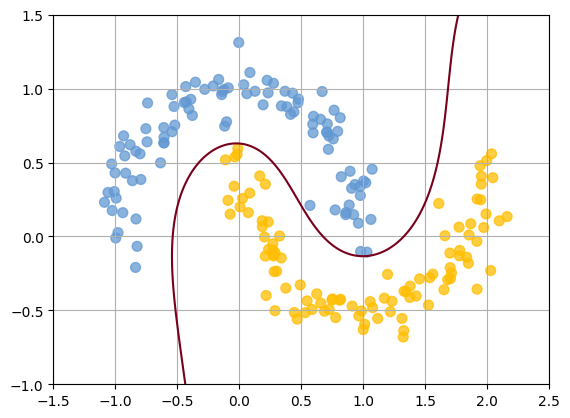

In [27]:
# print(Z)

# Define color Sky blue #6298D2 Turquoise #339C9C, Yellow #FFBE00, Dark brick #78001A
colors = {0: '#6298D2', 1: '#FFBE00'}
color_class = {0: 'a', 1: 'b'}
color_array = np.array([colors[label] for label in y])
color_class_array = np.array([color_class[label] for label in y])

# plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
handle = plt.contour(xx, yy, Z, levels=[0], linewidths=1.5, colors='#78001A')
# output the contour data to console

# output the contour data to a file
with open('contour_data.txt', 'w') as f:
    for contour in handle.allsegs[0]:
        for point in contour:
            f.write(f"({point[0]:.4f}, {point[1]:.4f})")
        f.write("\n")

handle = plt.scatter(X[:, 0], X[:, 1], c=color_array, s=50, cmap=plt.cm.Paired, alpha=0.75)

# output the scatter data to a file
with open('scatter_data.txt', 'w') as f:
    f.write("x y label\n")
    for i, point in enumerate(zip(X[:, 0], X[:, 1])):
        f.write(f"{point[0]:.4f} {point[1]:.4f} {color_class_array[i]}\n")

plt.grid(True)
plt.show()


         X1        X2        X3  label
0 -0.926767 -0.111073  0.086017      0
1 -0.917583  0.706006  0.058041      0
2  0.437984  0.899093  0.072543      0
3  0.089694  0.291446  0.070444      1
4  0.110672 -0.070806 -0.090376      1


0.9947916666666666


/tmp/ipykernel_9110/2360663814.py:69: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  handle = plt.scatter(X[:, 0], X[:, 1], c=color_array, s=50, cmap=plt.cm.Paired, alpha=0.75)


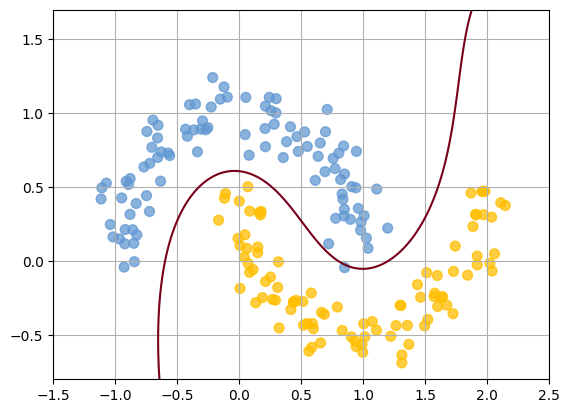

In [46]:
import matplotlib.pyplot as plt
delta = 256

original_X = df.iloc[:, 0].astype(np.float64).values + 1j * df.iloc[:, 1].astype(np.float64).values
original_Y = df.iloc[:, 2].astype(np.float64).values

# Print the first 5 rows of the dataframe
# print(original_X[:n//2])
# print(original_Y[:n//2])

original_X = original_X[:n * (len(original_X) // n)]
original_Y = original_Y[:n * (len(original_Y) // n)]

# Take only n * (length // n) points and encode_C_to_C
plaintext_set_X = encode(original_X, n, delta, type_is_C=1)
plaintext_set_Y = encode(original_Y, n, delta, type_is_C=1)

# print(plaintext_set_X[:n//2, 0])

# Encrypt the data
ciphertext_set_X = encrypt(plaintext_set_X, n, sigma, pk)
ciphertext_set_Y = encrypt(plaintext_set_Y, n, sigma, pk)

# Decrypt the data
decrypted_X = decrypt(ciphertext_set_X, n, sk)
decrypted_Y = decrypt(ciphertext_set_Y, n, sk)

# print(decrypted_X[:n//2, 0])

# Apply decode_C_to_C
decoded_X = decode(decrypted_X, n, delta, type_is_C=1)
decoded_Y = decode(decrypted_Y, n, delta, type_is_C=1)

# print(original_X[:n//2])
# print(decoded_X[:n//2])

recovered_X = decode(ciphertext_set_X[0], n, delta, type_is_C=1)

X = np.array((recovered_X.real, recovered_X.imag)).T
y = original_Y
# Apply SVM with RBF kernel
clf = SVC(kernel='rbf')
clf.fit(X, y)
print(clf.score(X, y))

# Plot the decision boundary
xx, yy = np.meshgrid(np.linspace(-1.5, 2.5, 500),
                     np.linspace(-0.8, 1.7, 500))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Define color Sky blue #6298D2 Turquoise #339C9C, Yellow #FFBE00, Dark brick #78001A
colors = {0: '#6298D2', 1: '#FFBE00'}
color_class = {0: 'a', 1: 'b'}
color_array = np.array([colors[label] for label in y])
color_class_array = np.array([color_class[label] for label in y])

# plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
handle = plt.contour(xx, yy, Z, levels=[0], linewidths=1.5, colors='#78001A')
# output the contour data to console

# output the contour data to a file
with open('contour_data.txt', 'w') as f:
    for contour in handle.allsegs[0]:
        for point in contour:
            f.write(f"({point[0]:.4f}, {point[1]:.4f})")
        f.write("\n")

handle = plt.scatter(X[:, 0], X[:, 1], c=color_array, s=50, cmap=plt.cm.Paired, alpha=0.75)

# output the scatter data to a file
with open('scatter_data.txt', 'w') as f:
    f.write("x y label\n")
    for i, point in enumerate(zip(X[:, 0], X[:, 1])):
        f.write(f"{point[0]:.4f} {point[1]:.4f} {color_class_array[i]}\n")

plt.grid(True)
plt.show()


In [33]:
# print this model's accuracy, precision, recall, f1-score
from sklearn.metrics import classification_report

print(clf.score(X, y))
print(classification_report(y, clf.predict(X)))


0.984375
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98        98
         1.0       0.98      0.99      0.98        94

    accuracy                           0.98       192
   macro avg       0.98      0.98      0.98       192
weighted avg       0.98      0.98      0.98       192



In [ ]:
# !pip install openpyxl
# !pip install lazypredict
import pandas as pd
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import classification_report

train = pd.read_csv('HE_moon_dataset.csv')
print(len(train))
train.head()

train = train.sample(frac=1).reset_index(drop=True)
y = train.pop('label')
X = train[['real', 'imag']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True, stratify=y)

clf = LazyClassifier(verbose=0, predictions=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

'''
Adjusted R-Squared: The closer to 1, the better the model.
R-Squared (coefficient of determination): The closer to 1, the better the model.
RMSE (Root Mean Squared Error): The closer to 0, the better the model.
'''
print(models)

# print the preditions by the best model
print(predictions['KNeighborsClassifier'])


192


100%|██████████| 31/31 [00:02<00:00, 10.70it/s]

[LightGBM] [Info] Number of positive: 77, number of negative: 76
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 105
[LightGBM] [Info] Number of data points in the train set: 153, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503268 -> initscore=0.013072
[LightGBM] [Info] Start training from score 0.013072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain